<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/master/AP/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

In [1]:
!pip install transformers

In [25]:
from transformers import BertModel, BertTokenizer
from transformers import AlbertModel, AlbertTokenizer
import nltk
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import math

In [3]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/ap_data/"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [6]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [7]:
def read_data(filename, labels, max_data_points=1000):

    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            text = cols[3]

            data.append(text)
            data_labels.append(labels[label])


    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)

    if max_data_points is None:
        return data, data_labels

    return data[:max_data_points], data_labels[:max_data_points]

In [8]:
labels=read_labels("%s/train.txt" % directory)

In [9]:
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)

In [10]:
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels, max_data_points=None)

In [11]:
test_x, test_y=read_data("%s/test.txt" % directory, labels, max_data_points=None)

In [12]:
#returns accuracy for classifier
def evaluate(model, x, y):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in zip(x, y):
            y_predictions=model.forward(x)
            for idx, y_pred in enumerate(y_predictions):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    correct = correct + 1
                total= total + 1
    return correct/total, total

In [13]:
#returns predictions from classifier and true values of y
def predictions(model, x, y):
    model.eval()
    predictions = []
    tru_labels = []
    with torch.no_grad():
        for batch_x, batch_y in zip(x, y):
            y_predictions = model.forward(batch_x)
            pred_labels = torch.argmax(y_predictions, dim=1)
            predictions.extend(pred_labels.cpu().numpy())
            tru_labels.extend(batch_y.cpu().numpy())
    return predictions, tru_labels


In [14]:
#original BERT model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, params):
        super().__init__()

        self.model_name = bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=params["doLowerCase"])
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.num_labels = params['num_labels']
        self.fc = nn.Linear(self.bert.config.hidden_size, self.num_labels)

    def forward(self, batch_x):
        b_output = self.bert(input_ids=batch_x["input_ids"],
                                attention_mask=batch_x["attention_mask"],
                                token_type_ids=batch_x.get("token_type_ids", None),
                                output_hidden_states=True)
        p_output = b_output.pooler_output
        lts = self.fc(p_output)
        return lts

    def get_batches(self, all_x, all_y, batch_size=16, max_toks=510):
        x_batches = []
        y_batches = []

        for i in range(0, len(all_x), batch_size):
            x = all_x[i:i + batch_size]
            x_batch = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            y_batch = all_y[i:i + batch_size]

            x_batches.append(x_batch.to(device))
            y_batches.append(torch.LongTensor(y_batch).to(device))

        return x_batches, y_batches

In [29]:
class ALBERTClassifier(nn.Module):
    def __init__(self, albert_model_name, params):
        super().__init__()

        self.model_name = albert_model_name
        self.tokenizer = AlbertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"])
        self.albert = AlbertModel.from_pretrained(self.model_name)

        self.num_labels = params["num_labels"]
        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
        x_batches = []
        y_batches = []
        for i in range(0, len(all_x), batch_size):
            x = all_x[i:i+batch_size]
            x_batch = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            y_batch = all_y[i : i +batch_size]
            x_batches.append(x_batch.to(device))
            y_batches.append(torch.LongTensor(y_batch).to(device))
        return x_batches, y_batches

    def forward(self, batch_x):
        alt_output = self.albert(input_ids=batch_x["input_ids"],
                                    attention_mask=batch_x["attention_mask"],
                                    token_type_ids=batch_x["token_type_ids"],
                                    output_hidden_states=True)

        albert_hdn_states = alt_output['hidden_states']
        output = albert_hdn_states[-1][:, 0, :]
        output = self.fc(output)
        return output.squeeze()

In [15]:
#BERT with attention implemented
class Attention(nn.Module):
    def __init__(self, embed_dim):
        super(Attention, self).__init__()
        self.embed_dim = embed_dim
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        self.linear = nn.Linear(embed_dim, 1, bias=False)

    def forward(self, outputs, mask):
        s = self.linear(outputs)
        s = self.tanh(s).squeeze(2)
        s = s.masked_fill(mask == 0, -1e9)
        attn_weights = self.softmax(s)
        vtr = torch.sum(attn_weights.unsqueeze(-1) * outputs, dim=1)
        return vtr

class BERTClassifierWithAttention(nn.Module):
    def __init__(self, bert_model_name, params):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.attention = Attention(self.bert.config.hidden_size)
        self.fc = nn.Linear(self.bert.config.hidden_size, params['num_labels'])

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)

        last_hdn_states = outputs.last_hidden_state
        vtr = self.attention(last_hdn_states, attention_mask)

        lts = self.fc(vtr)
        return lts

class AlbertClassifierWithAttention(nn.Module):
    def __init__(self, albert_model_name, params):
        super().__init__()
        self.albert = AlbertModel.from_pretrained(albert_model_name)
        self.attention = Attention(self.albert.config.hidden_size)
        self.fc = nn.Linear(self.albert.config.hidden_size, params['num_labels'])

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.albert(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)

        last_hdn_states = outputs.last_hidden_state
        vtr = self.attention(last_hdn_states, attention_mask)

        lts = self.fc(vtr)
        return lts

In [32]:
def train(model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None, learning_rate=1e-5, batch_size=32, num_epochs=10):
    if model_name.startswith("bert"):
        model_class = BERTClassifier
    elif model_name.startswith("albert"):
        model_class = AlbertClassifierWithAttention
    else:
        raise ValueError("Invalid model name. Must start with 'bert' or 'albert'.")

    params = {
        'num_labels': len(labels),
        'doLowerCase': doLowerCase,
        'embedding_size': embedding_size
    }

    model = model_class(model_name, params)
    model.to(device)

    batch_x, batch_y = model.get_batches(train_x, train_y, batch_size=batch_size)
    dev_batch_x, dev_batch_y = model.get_batches(dev_x, dev_y, batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()

    best_dev_acc = 0.
    patience = 5
    best_epoch = 0
    total_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        for x, y in zip(batch_x, batch_y):
            y_pred = model.forward(x)
            loss = cross_entropy(y_pred.view(-1, model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        dev_accuracy, _ = evaluate(model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch = epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return model

In [16]:
def confidence_intervals(accuracy, n, significance_level):
    c_value = (1-significance_level)/2
    z = -1 * norm.ppf(c_value)
    se = math.sqrt((accuracy * (1-accuracy))/n)
    return accuracy - (se * z), accuracy + (se * z)

In [33]:
# bert-base -- slow on laptop; better on Colab
bert_model_name = "bert-base-cased"
model_filename = "mybert.model"
embedding_size = 768
doLowerCase = False

model = train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size, doLowerCase)
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n = evaluate(model, test_batch_x, test_batch_y)

lower, upper = confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Epoch 0, dev accuracy: 0.540
Epoch 1, dev accuracy: 0.520
Epoch 2, dev accuracy: 0.560
Epoch 3, dev accuracy: 0.600
Epoch 4, dev accuracy: 0.610
Epoch 5, dev accuracy: 0.610
Epoch 6, dev accuracy: 0.660
Epoch 7, dev accuracy: 0.690
Epoch 8, dev accuracy: 0.700
Epoch 9, dev accuracy: 0.720

Best Performing Model achieves dev accuracy of : 0.720
Test accuracy for best dev model: 0.770, 95% CIs: [0.688 0.852]



In [30]:
#running ALBERT classifier
albert_model_name = "albert-base-v2"
model_filename = "myalbert.model"
embedding_size = 768
doLowerCase = False

model = train(albert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n = evaluate(model, test_batch_x, test_batch_y)

lower, upper = confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Epoch 0, dev accuracy: 0.550
Epoch 1, dev accuracy: 0.610
Epoch 2, dev accuracy: 0.680
Epoch 3, dev accuracy: 0.710
Epoch 4, dev accuracy: 0.740
Epoch 5, dev accuracy: 0.740
Epoch 6, dev accuracy: 0.710
Epoch 7, dev accuracy: 0.670
Epoch 8, dev accuracy: 0.680
Epoch 9, dev accuracy: 0.690

Best Performing Model achieves dev accuracy of : 0.740
Test accuracy for best dev model: 0.750, 95% CIs: [0.665 0.835]



In [31]:
#baynesian optimization
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer

def objective(params):
    learning_rate, batch_size, num_epochs = params
    model = train(albert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels,
                  embedding_size=embedding_size, doLowerCase=doLowerCase,
                  learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
    dev_batch_x, dev_batch_y = model.get_batches(dev_x, dev_y)
    dev_accuracy, _ = evaluate(model, dev_batch_x, dev_batch_y)
    return -dev_accuracy

albert_model_name = "albert-base-v2"
model_filename = "myalbert.model"
embedding_size = 768
doLowerCase = False

ranges = [
    Real(1e-6, 1e-4, name='learning_rate'),
    Integer(16, 64, name='batch_size'),
    Integer(5, 20, name='num_epochs')
]

optimized = gp_minimize(objective, ranges, n_calls=2, n_initial_points=2)

optimal_learning_rate, optimal_batch_size, optimal_num_epochs = optimized.x
print(f"Optimal hyperparameters: learning_rate={optimal_learning_rate}, batch_size={optimal_batch_size}, num_epochs={optimal_num_epochs}")

final_model = train(albert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels,
                    embedding_size=embedding_size, doLowerCase=doLowerCase,
                    learning_rate=optimal_learning_rate, batch_size=optimal_batch_size, num_epochs=optimal_num_epochs)

test_batch_x, test_batch_y = final_model.get_batches(test_x, test_y)
accuracy, test_n = evaluate(final_model, test_batch_x, test_batch_y)

lower, upper = confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00
Epoch 0, dev accuracy: 0.550
Epoch 1, dev accuracy: 0.710
Epoch 2, dev accuracy: 0.620
Epoch 3, dev accuracy: 0.550


KeyboardInterrupt: 

In [ ]:
predictions, true_labels = predictions(model, test_batch_x, test_batch_y)

In [ ]:
np.sum(np.array(predictions) == np.array(true_labels))

74

In [ ]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.740, 95% CIs: [0.654 0.826]



In [ ]:
import pandas as pd
"""randomly selected train dev and test"""
#code used to create dev, train, and txt files (from adjuncted csv)
#df=pd.read_csv("%s/adj.csv" % directory)
#df = pd.read_csv("adj.csv")
#df = df.sample(n = 500, replace = False)
#train = df[:300]
#dev = df[300: 400]
#test = df[400:]

#train.to_csv("train.txt", sep='\t', header=False, index=False)
#dev.to_csv("dev.txt", sep='\t', header=False, index=False)
#test.to_csv("test.txt", sep='\t', header=False, index=False)


'randomly selected train dev and test'

# Backtranslation

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(text, source_lang='en', target_lang='fr'):
    fwd_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}')
    fwd_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}')

    bwd_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}')
    bwd_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}')

    translated = fwd_model.generate(**fwd_tokenizer(text, return_tensors="pt", padding=True))
    target_text = fwd_tokenizer.decode(translated[0], skip_special_tokens=True)

    back_translated = bwd_model.generate(**bwd_tokenizer(target_text, return_tensors="pt", padding=True))
    source_text = bwd_tokenizer.decode(back_translated[0], skip_special_tokens=True)

    return source_text

In [ ]:
augmented_text = train['original_text'][:25].apply(lambda x: back_translate(x, src_lang='en', tgt_lang='fr'))

In [ ]:
augmented_df = train.iloc[:25]
augmented_df['augmented_text'] = augmented_text

augmented_df.to_csv("augmented_first25.txt", sep='\t', header=False, index=False)

In [ ]:
augmented_text2 = train['original_text'][25:50].apply(lambda x: back_translate(x, src_lang='en', tgt_lang='fr'))
augmented_df2 = train.iloc[25:50]
augmented_df2['augmented_text'] = augmented_text2

augmented_df2.to_csv("augmented_2.txt", sep='\t', header=False, index=False)

In [ ]:
augmented_text3 = train['original_text'][50:75].apply(lambda x: back_translate(x, src_lang='en', tgt_lang='fr'))
augmented_df3 = train.iloc[50:75]
augmented_df3['augmented_text'] = augmented_text3

augmented_df3.to_csv("augmented_3.txt", sep='\t', header=False, index=False)

In [ ]:
augmented_text4 = train['original_text'][75:100].apply(lambda x: back_translate(x, src_lang='en', tgt_lang='fr'))
augmented_df4 = train.iloc[75:100]
augmented_df4['augmented_text'] = augmented_text4

augmented_df4.to_csv("augmented_4.txt", sep='\t', header=False, index=False)

In [ ]:
print(train[['original_text', 'augmented_text']])

Backtranslation takes ~1 hour to run and produce augmented data.

# Part A Summary
We decided to go with the BERT model for our task because it’s most helpful for picking up surrounding context and assessing humor in text. There are a few changes we implemented to improve our model.

Augmented data/Back Translation - We wanted to introduce variation in the data and make it more robust to increase model performance. By doing this the model would ideally better capture nuances in humor leading to more accurate predictions.

ALBERT Classifier - We thought that ALBERT's parameter reduction techniques would help improve efficiency and enable better performance with limited labeled data.

Bayesian Optimization - We implemented a ski-kit optimizer into our ALBERT classifier to tune hyperparameters and improve accuracy.

Layer Adjustments - Instead of using the baseline CLS token representation in the given BERT notebook, we used pooled output and attention mechanisms to aggregate information across all tokens in order to improve our accuracy.

Accuracy: 0.740

CI: [0.654 0.826]


##Analysis

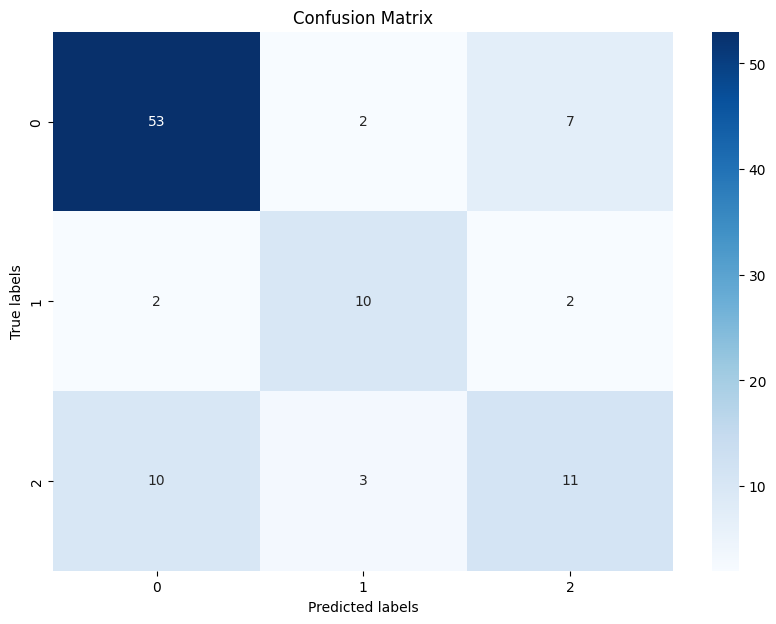

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_y, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
error_cases = pd.DataFrame()

In [ ]:
error_cases['original_text'] = test_x
error_cases['annotated_label'] = test_y
error_cases['model_prediction'] = predictions

In [ ]:
part_a = error_cases[error_cases['annotated_label'] == 0]
error_cases_02 = part_a[part_a['model_prediction'] == 2]

In [ ]:
part_one = error_cases[error_cases['annotated_label'] == 2]
error_cases_20 = part_a[part_a['model_prediction'] == 0]

In [ ]:
np.array(error_cases_20['original_text'])[10]

'"My students often ask me, ""What is sociology?"" And I tell them it\'s the study of the way in which human beings are shaped by things that they don\'t see. And they say, ""So, how can I be a sociologist? How can I understand those invisible forces?"" And I say, ""Empathy. Start with empathy. It all begins with empathy. Take yourself out of your shoes, put yourself into the shoes of another person.""Here, I\'ll give you an example. So I imagine my life if, a hundred years ago, China had been the most powerful nation in the world and they"\n'

# Evaluation/Discussion

**Most common mistaken labels:**

The labels of 0 and 2 were often mistaken for each other. For example, we had 10 errors where our model predicted the label was 0 when it was actually 2. This means even though a category was labeled as funny, our model assessed it as not funny. The same situation occurred in the opposite way where our model predicted a text would be funny when it actually had a label as 0. We want to take a closer look at test examples to see why this error is coming up.

**Systematic mistakes & biases:**

When reading through test predictions, we noticed that in the texts we labeled as not funny but the model predicted as funny, there are niche references to pop culture. In our view, they were attempted jokes or comments that had the intention to be humorous but didn’t really have a punchline. The model seems to favor pop culture references and connects it to humor automatically. This brings up a bias on our end; because all annotators are the same age and in the same environment, we tend to have a pretty similar sense of humor. We aren’t in the age bracket to understand certain older references and therefore may have missed jokes that other people would pick up on and find amusing.

Another issue we found is that the model doesn’t pick up on dark humor. There are certain examples where we labeled the text as funny because even though the topic was on the “darker” side, the speaker incorporated humor throughout their speech. However, the model seemed to have zoned in on the serious topic and labeled it as not funny.

**Dataset balance:**

In our dataset, there is a huge prevalence of "Not Funny" data or labels with the value of 0. This negatively impacts our model since our model doesn't have enough data points of other types of data ("Funny" and "Neutral"). We also classified inputs who didn't fit our general structure of Ted Talks (singing or poems) as 0, increasing the total number of "Not Funny" data labels. With data sets like ours, we want to duplicate examples from the minority data values.